# Caso práctico: Support Vactor Machine (SVM)

## DataSet: Detección de URL's maliciosas.

### Descripción: 

# Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np 
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

## Funciones Auxiliares

In [5]:
#Construccion 

def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [6]:
# Representacion gráfica del límite de decisión
def plot_svm_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary. w0*x0 + w1*w1 + b = 0
    # => x1 = -w0/w1 * x0 -b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svm = svm_clf.support_vectors_
    plt.scatter(svs [:, 0], svs[:, 1],s = 180, facecolors= '#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0,gutter_up, 'k--', linewhidth=2)
    plt.plot(x0, gutter_down, ('k--'), linewhidth=2)

# 1.-Lectura del DataSet

In [8]:
df = pd.read_csv('datasets/datasets/FinalDataset/Phishing.csv')

In [9]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
5,0,2,10,5.5,9,4.100000,2,15,11,0,...,-1,-1,-1,0.732981,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
6,0,2,12,4.5,6,5.333334,2,24,9,0,...,0,0,-1,0.692383,0.939794,0.910795,0.673973,0.00000,-1.000000,benign
7,0,2,11,3.5,4,3.909091,2,15,6,0,...,0,0,-1,0.707365,0.916667,0.916667,0.690332,0.00000,-1.000000,benign
8,0,2,9,2.5,3,4.555555,2,6,3,0,...,1,0,-1,0.742606,1.000000,0.785719,0.808833,1.00000,-1.000000,benign
9,0,2,13,4.5,6,5.307692,2,16,9,1,...,-1,-1,-1,0.734633,0.939794,-1.000000,-1.000000,-1.00000,-1.000000,benign


In [10]:
df['URL_Type_obf_Type'].value_counts()

URL_Type_obf_Type
benign      7781
phishing    7586
Name: count, dtype: int64

In [11]:
is_null = df.isna().any()
is_null[is_null]

avgpathtokenlen             True
NumberRate_DirectoryName    True
NumberRate_FileName         True
NumberRate_Extension        True
NumberRate_AfterPath        True
Entropy_DirectoryName       True
Entropy_Filename            True
Entropy_Extension           True
Entropy_Afterpath           True
dtype: bool

In [12]:
# Comprobar si se tiene la existencia de valores infinitos
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

argPathRatio    True
dtype: bool

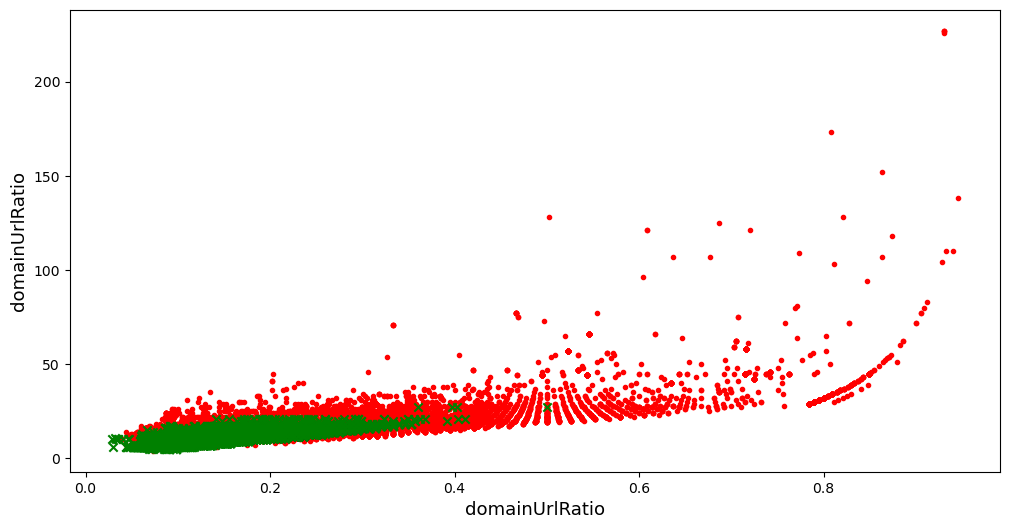

In [13]:
# Representación gráfica de dos características.
plt.figure(figsize = (12,6))
plt.scatter(df['domainUrlRatio'][df['URL_Type_obf_Type'] == 'phishing'], df['domainlength'][df['URL_Type_obf_Type']=='phishing'], c='r', marker='.')
plt.scatter(df['domainUrlRatio'][df['URL_Type_obf_Type'] == 'benign'], df['domainlength'][df['URL_Type_obf_Type']=='benign'], c='g', marker='x')
plt.xlabel('domainUrlRatio', fontsize=13) 
plt.ylabel('domainUrlRatio', fontsize=13)      
plt.show()            

## 3.- División de datos 

In [15]:
train_set, val_set, test_set = train_val_test_split(df)


In [16]:
X_train = train_set.drop("URL_Type_obf_Type", axis=1)
y_train = train_set["URL_Type_obf_Type"].copy()

X_val = val_set.drop("URL_Type_obf_Type", axis=1)
y_val = val_set["URL_Type_obf_Type"].copy()

X_test = test_set.drop("URL_Type_obf_Type", axis=1)
y_test = test_set["URL_Type_obf_Type"].copy()

## 4.- Preparación del DataSet

In [18]:
# Eliminar los atributos que tengan valores infinitos
X_train = X_train.drop('argPathRatio', axis=1)
X_val = X_val.drop('argPathRatio', axis=1)
X_test = X_test.drop('argPathRatio', axis=1)

In [19]:
# Rellenar los valores nulos con la mediana.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [20]:
# Rellenar los valores nulos 
X_train_prep = imputer.fit_transform(X_train)
X_val_prep = imputer.fit_transform(X_val)
X_test_prep = imputer.fit_transform(X_test)


In [21]:
# Tansformar el resultado a un DataFrame de pandas
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [22]:
X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
2134,0.0,2.0,6.0,2.000000,2.0,8.666667,2.0,17.0,10.0,0.0,...,2.0,0.0,0.0,-1.0,0.681183,0.827729,0.702637,0.849605,0.000000,-1.000000
9178,0.0,4.0,18.0,3.250000,5.0,1.000000,4.0,18.0,13.0,2.0,...,12.0,3.0,0.0,4.0,0.695232,0.820160,0.682849,0.875578,0.000000,0.778747
13622,0.0,3.0,3.0,6.666666,14.0,4.000000,3.0,1.0,1.0,1.0,...,1.0,0.0,0.0,-1.0,0.836006,0.869991,0.879588,1.000000,0.000000,-1.000000
15182,0.0,3.0,5.0,3.333333,4.0,3.000000,3.0,5.0,2.0,0.0,...,2.0,1.0,0.0,-1.0,0.731804,0.796490,0.796658,1.000000,1.000000,-1.000000
8013,74.0,2.0,13.0,9.500000,17.0,7.875000,2.0,21.0,29.0,26.0,...,4.0,5.0,4.0,3.0,0.653371,0.820569,0.758055,0.714969,0.712215,0.708031
12408,0.0,3.0,4.0,8.333333,19.0,3.750000,3.0,5.0,1.0,0.0,...,2.0,0.0,0.0,-1.0,0.726479,0.789538,0.800705,1.000000,0.000000,-1.000000
509,20.0,2.0,13.0,4.500000,6.0,3.000000,2.0,24.0,17.0,0.0,...,1.0,14.0,13.0,12.0,0.678515,0.796658,0.871049,0.695112,0.701662,0.698106
10714,0.0,3.0,8.0,6.666666,14.0,4.250000,3.0,11.0,5.0,0.0,...,4.0,0.0,0.0,-1.0,0.745348,0.869991,0.788921,1.000000,0.000000,-1.000000
3986,0.0,2.0,6.0,6.500000,10.0,4.500000,2.0,7.0,7.0,0.0,...,2.0,0.0,0.0,-1.0,0.760843,0.798231,0.822491,0.796670,0.000000,-1.000000
748,0.0,2.0,8.0,4.000000,5.0,5.750000,2.0,14.0,14.0,1.0,...,2.0,0.0,0.0,-1.0,0.709062,0.929897,0.884735,0.674994,0.000000,-1.000000


In [23]:
# Comprobar si existen datos nulos en el conjunto de datos de entrenamiento 
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

## 5.- SVM: Kernel

Un kernel es una muestra 
### 5.1.- Conjunto de Datos Reducido

##### Entrenamiento del algoritmo con un DataSet reducido

In [25]:
#Reducir el DataSet para representarlo gráficamente
X_train_reduced = X_train_prep[['domainUrlRatio', 'domainlength']].copy()
X_val_reduced = X_val_prep[['domainUrlRatio','domainlength']].copy()

In [26]:
X_train_reduced

,domainUrlRatio,domainlength
2134,0.072464,5.0
9178,0.166667,16.0
13622,0.511628,22.0
15182,0.315789,12.0
8013,0.107527,20.0
...,...,...
5191,0.116667,14.0
13418,0.477273,21.0
5390,0.157895,9.0
860,0.072917,7.0


In [27]:
from sklearn.svm import SVC
# SVM Large Margin Classificador

svm_clf = SVC(kernel = 'linear', C=50)
svm_clf.fit(X_train_reduced, y_train)

SVC(C=50, kernel='linear')

##### Representación del limite de decisión 

In [29]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
 
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0,gutter_up, 'k--', linewidth=2)
    plt.plot(x0, gutter_down, ('k--'), linewidth=2)

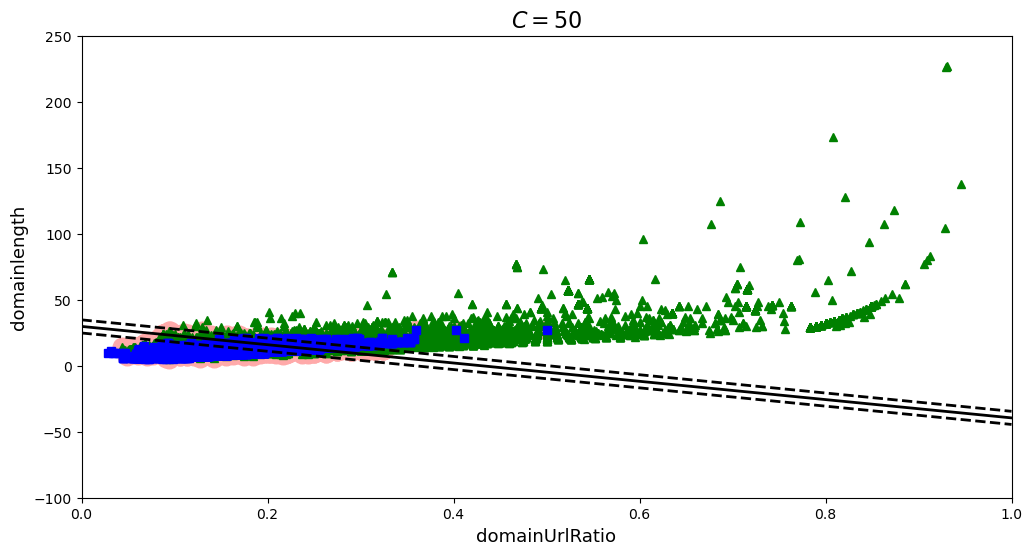

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train=='phishing'], X_train_reduced.values[:, 1][y_train=='phishing'],'g^') 
plt.plot(X_train_reduced.values[:, 0][y_train=='benign'], X_train_reduced.values[:, 1][y_train=='benign'],'bs')
plot_svc_decision_boundary(svm_clf, 0,1)
plt.title('$C = {}$'.format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel('domainUrlRatio', fontsize=13)
plt.ylabel('domainlength', fontsize=13)
plt.show()

In [31]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    D = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = - w[0] / w[1] * x0 - D / w[1]
    margin = 1 / w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA', edgecolors='k', zorder=3)    

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=4)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=4)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=4)



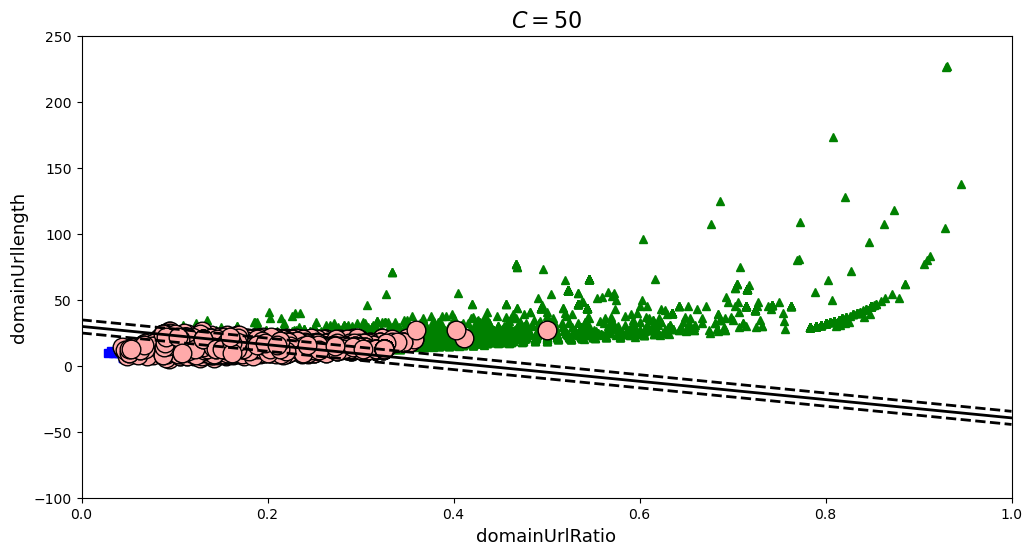

In [32]:
plt.figure(figsize = (12, 6))
plt.plot(X_train_reduced.values[:, 0] [y_train == "phishing"], X_train_reduced.values[:, 1][y_train == "phishing"], "g^", zorder=1)
plt.plot(X_train_reduced.values[:, 0] [y_train == "benign"], X_train_reduced.values[:, 1][y_train == "benign"], "bs", zorder=2)
plot_svc_decision_boundary(svm_clf, 0, 1) # Frontera de decisión. (Guiones de color negro)

# Personalización de la impresión
plt.title("$C = {}$".format(svm_clf.C), fontsize = 16)
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize = 13)
plt.ylabel("domainUrllength", fontsize = 13)
plt.show()

#### Predicción con un DataSet Reducido.

In [34]:
y_pred = svm_clf.predict(X_val_reduced)

In [35]:
print('F1 Score:', f1_score(y_pred, y_val, pos_label = 'phishing'))

F1 Score: 0.8142614601018676


#### Como se vera más adelante para determinados kernels es muy importante escalar el DataSet en este caso para el kernel lineal no es tan relevante, aunque es posible que proporcione mejores resultados.

In [37]:
svm_clf_sc = Pipeline([
    ('scaler', RobustScaler()),
    ('linear_svc', SVC(kernel='linear', C=50)),
 ])

svm_clf_sc.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svc', SVC(C=50, kernel='linear'))])

In [38]:
y_pred = svm_clf_sc.predict(X_val_reduced)

In [39]:
print('F1 Score:', f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.8141592920353983


### 5.2 DataSetCompleto

In [41]:
# Entrenamiento con todo el DataSet 
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train_prep, y_train)

SVC(C=1, kernel='linear')

In [42]:
y_pred = svm_clf.predict(X_val_prep)

In [43]:
print('F1 Score:', f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.961133069828722


## 6.- SVM: Kernel no lineal

#### Entrenammiento del algoritmo con un DataSet reducido.  

In [46]:
# Para representar el limite de decisión, se tiene que pasar la variable objetivo a númerica.
y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [47]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=20, loss='hinge', random_state=42, max_iter=100000))
 ])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)

/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=20, loss='hinge', max_iter=100000,
                           random_state=42))])

### Representación del limite de decision. 

In [49]:
def plot_dataset(X, y):
    plt.plot(X[:,0][y==1], X[:, 1][y==1],  'g.')
    plt.plot(X[:,0][y==0], X[:, 1][y==0], 'b.')

/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


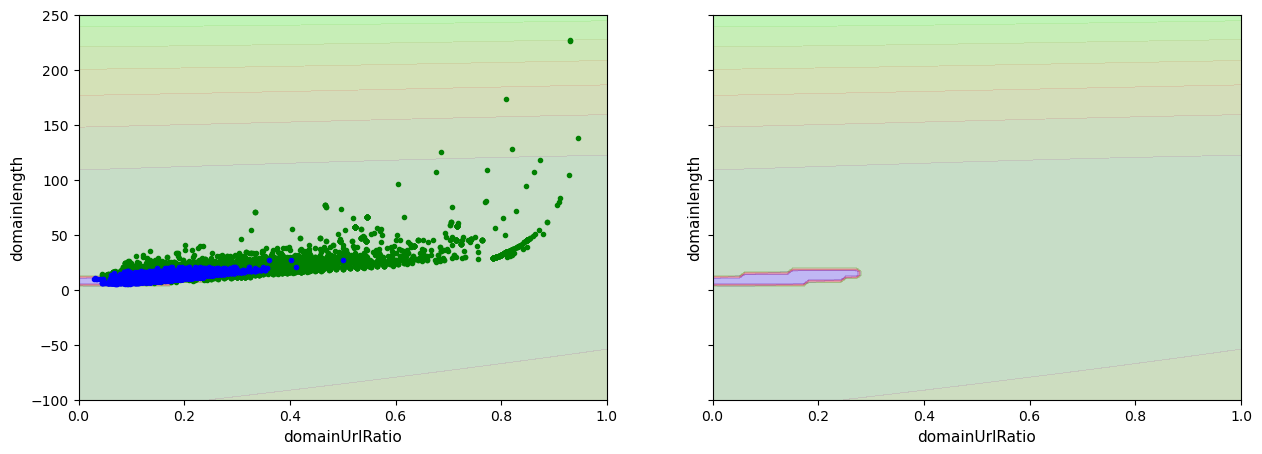

In [50]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel('domainUrlRatio', fontsize=11)
plt.ylabel('domainlength', fontsize=11)
plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel('domainUrlRatio', fontsize=11)
plt.ylabel('domainlength', fontsize=11)
plt.show()

##### Predicción del DataSet Reducido. 

In [91]:
y_pred = polynomial_svm_clf.predict(X_val_reduced)

In [93]:
print('F1 Score:',f1_score(y_pred, y_val_num))

F1 Score: 0.857451403887689


## 6.2 Polynomial Kernel(II)

#### Existe una forma más sencilla de entrenar un algoritmo SVM que utilice el parametro **Kernel** de la propia función implementada en sklearn.

#### Entrenamiento del algoritmo con un DataSet reducido.

In [96]:
svm_clf = SVC(kernel='poly', degree=3, coef0=10, C=20)
svm_clf.fit(X_train_reduced, y_train_num)

SVC(C=20, coef0=10, kernel='poly')

/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/marlen/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


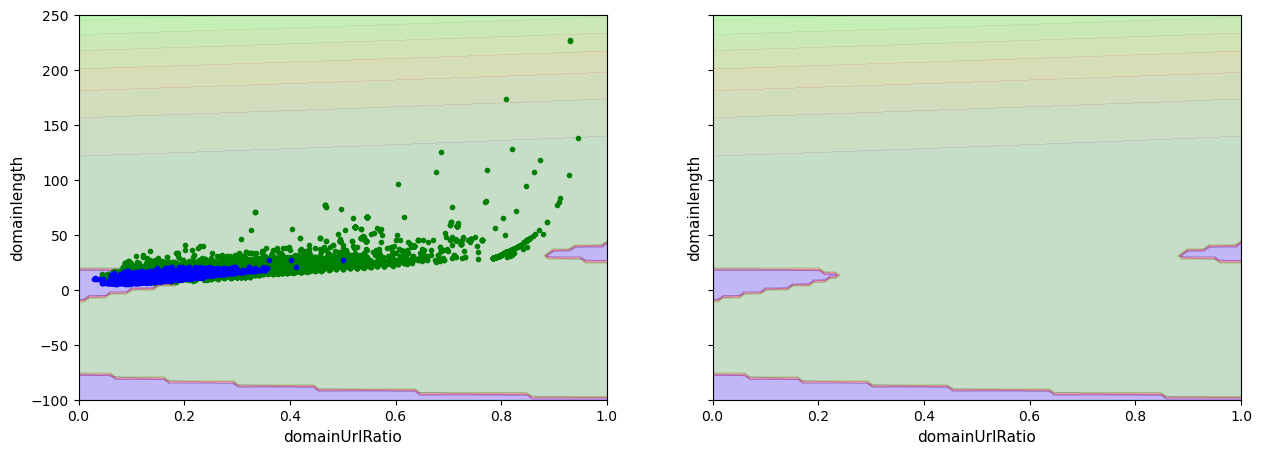

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel('domainUrlRatio', fontsize=11)
plt.ylabel('domainlength', fontsize=11)
plt.sca(axes[1])
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel('domainUrlRatio', fontsize=11)
plt.ylabel('domainlength', fontsize=11)
plt.show()